## 签到文本处理

In [1]:
import re
import pandas as pd

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
path_in = '/data/weibo/shanghai/'
path_out = 'data/processing/'

df = pd.read_csv(path_in+'data_2019.csv')
poi = pd.read_csv(path_in+'shanghai-poi-2019.csv')
loc = pd.read_csv(path_in+'shanghai-poi-loc.csv')
poi_mid = pd.read_csv(path_in+'shanghai-poi-mid-2019.csv')

In [3]:
df0 = (
    df
    .merge(poi_mid.drop(columns='ts_created'), on='mid', how='left')
    .dropna(subset='poiid')
    .merge(poi, on='poiid', how='left')
    .merge(loc, on='poiid', how='left')
)

In [4]:
def remove_wbicon(text):
    return re.sub(re.compile(r'(<i\s+.*?wbicon.*?>.*?</i>)', re.S), '', text)

def remove_tag(text):
    return re.sub(re.compile(r'<(.*?)>', re.S), '', text)
    
def remove_topic(text):
    return re.sub(r'#\w+#', '', text)

def remove_english(text):
    return re.sub(r'[a-zA-Z]+', '', text)

def remove_english_punctuation(text):
    # 匹配英文标点符号的正则表达式
    english_punctuation_pattern = re.compile(r'[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]')
    return english_punctuation_pattern.sub('', text)

def replace_imgicon(text):
    # 保留<img title="xxx">中的title信息
    return re.sub(re.compile(r'<img.*?(alt=["|\']{0,1}(.*?)["|\']{0,1}|title=["|\']{0,1}(.*?)["|\']{0,1})\s+.*?>', re.S|re.M), '\g<2>', text).strip()

def replace_tag(text):
    return re.sub(re.compile(r'<br/>',re.S),'\n',text)
    
def remove_link(text):
    # 移除 poi链接、视频链接、直播链接
    urls=re.findall(r"<a.*?href=.*?<\/a>", text, re.I|re.S|re.M)
    url=[u for u in urls if '>2<' in u or 'location_default.png' in u or '视频</a>' in u or '视频</span></a>' in u or '直播</a>' in u]
    if len(url)>0:
        for u in url:
            text=text.replace(u,'')
    return text.replace('网页链接','')

def remove_emoji(text):
    return ''.join(re.findall(r'[\u4e00-\u9fff\u3002\uff1b\uff0c\uff1a\u201c\u201d\uff08\uff09\u3001\uff1f\u300a\u300b]', text))
    
# 移除文本内的连续重复内容
# 移除连续发生3次及以上次数的重复性内容
# 重复内容的字符串长度>=3
def drop_duplicated(text):
    return re.sub(re.compile(r'([\s|\S]{2,}?)\1{2,}',re.S|re.M),'\g<1>',text)

# def preprocess_text(text):
#     functions = [remove_wbicon, remove_tag, remove_topic, remove_english, remove_english_punctuation, replace_imgicon, replace_tag, remove_link, drop_duplicated]
#     for func in functions:
#         text = func(text)
#     return text

pipeline = [
    str.lower, 
    str.strip,
    remove_wbicon,
    remove_tag, 
    remove_topic, 
    remove_english, 
    remove_english_punctuation, 
    replace_imgicon,
    remove_link,
    remove_emoji
]

# 目标：保留话题的文字、移除poi超链接、视频超链接、保留表情图片中的标题文字、移除其他html标签
def prepare(text, pipeline):
    tokens = text
    for transform in pipeline: 
        tokens = transform(tokens)
    return tokens

In [10]:
df0['text'] = df0['message'].apply(str)
df0['text'] = df0['text'].parallel_apply(prepare, pipeline=pipeline)
df0 = df0.drop_duplicates(subset='mid').reset_index(drop=True)

In [11]:
df0.drop(columns='message').to_csv(path_out+'shanghai_2019.csv', index=False)

## 用户签到地共现数量计算

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
df = pd.read_csv('data/processing/shanghai_2019.csv')

In [15]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6550912 entries, 0 to 6550911
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   mid            6550912 non-null  int64  
 1   userid         6550912 non-null  int64  
 2   ts_created     6550912 non-null  object 
 3   poiid          6550912 non-null  object 
 4   title          6549185 non-null  object 
 5   category_name  5474986 non-null  object 
 6   lon            6536588 non-null  float64
 7   lat            6536588 non-null  float64
 8   text           6548510 non-null  object 
dtypes: float64(2), int64(2), object(5)
memory usage: 449.8+ MB


In [16]:
gdf = gpd.read_file('https://geojson.cn/api/data/310000.json')  # 读取研究区矢量数据

# 先过滤唯一值的点从而保留上海大市的签到
df0 = df.groupby(['lon','lat']).size().reset_index(name='count')
gdf0 = gpd.GeoDataFrame(df0, geometry=gpd.points_from_xy(df0.lon,df0.lat), crs=gdf.crs)
gdf0 = gpd.clip(gdf0, gdf)

ERROR 1: PROJ: proj_create_from_database: Open of /home/jupyter-hanshilingyun/.conda/envs/datasci/share/proj failed
Skipping field center: unsupported OGR type: 3
Skipping field centroid: unsupported OGR type: 3
Skipping field offset: unsupported OGR type: 3


In [17]:
gdf0

,lon,lat,count,geometry
71421,121.813637,30.846705,4,POINT (121.81364 30.8467)
71430,121.815013,30.848136,2,POINT (121.81501 30.84814)
71450,121.817525,30.848841,5,POINT (121.81753 30.84884)
71517,121.829696,30.850847,14,POINT (121.8297 30.85085)
71516,121.829610,30.851585,6,POINT (121.82961 30.85159)
...,...,...,...,...
16391,121.387076,31.631833,11,POINT (121.38708 31.63183)
16607,121.388395,31.633453,46,POINT (121.3884 31.63345)
16185,121.385497,31.634714,44,POINT (121.3855 31.63471)
16224,121.385794,31.669235,1,POINT (121.38579 31.66923)


In [18]:
# 保留上海大市签到
# 删除文本长度<=4
df = df[df.lon.isin(gdf0.lon) & df.lat.isin(gdf0.lat)].copy()
df = df[df['text'].str.len()>4].copy()

In [20]:
df0 = df.groupby(['poiid']).agg({'mid':'nunique','userid':'nunique'}).reset_index()
df0

,poiid,mid,userid
0,1000705141,1,1
1,1000986202,1,1
2,1000990505,4,4
3,1000991360,1,1
4,1001036239,4,4
...,...,...,...
73254,B209475DDB6AAAFA449D,20,20
73255,B209475DDB6DA3FB4992,6,6
73256,B209475DDB6DABF5439B,11,11
73257,B209475DDB6FA0F8469A,18,18


In [21]:
# 签到量>100
# 签到人数>5
# 签到点结尾不是00000000
df0 = df0[df0.poiid.str.endswith('00000000')==False].copy()

df = df[df.poiid.isin(
    df0[(df0.mid>10) & (df0.userid>1)].poiid
)].copy()

In [22]:
df0 = df.groupby(['userid','poiid']).size().reset_index().groupby('userid').size().reset_index(name='Count')
df0

,userid,Count
0,39021,1
1,94555,2
2,103575,1
3,103759,12
4,104957,2
...,...,...
1465324,7364899845,1
1465325,7365241601,1
1465326,7365251401,2
1465327,7365295889,1


In [23]:
# 用户签到过的不同地点>2
df = df[df.userid.isin(
    df0[df0.Count>=2].userid
)].copy()

In [24]:
# 时间格式转换
# 按照用户和时间排序
df['ts_created'] = pd.to_datetime(df['ts_created'], format='mixed')
checkins_poi = df.sort_values(['userid','ts_created']).reset_index(drop=True)[['userid','poiid','ts_created']].copy()

In [25]:
# 聚合用户
# 下移表格得到点对
# 删除空值（最后一行无对应后续签到点）
# 不需要自循环点对（poiid!=next_poiid）
checkins_poi['next_poiid'] = checkins_poi.groupby('userid')['poiid'].shift(-1)

checkins_poi = (checkins_poi
                .dropna()
                .drop(columns='ts_created')
                .query('poiid!=next_poiid')
                .groupby(['poiid','next_poiid'])
                .agg({"userid":"count"}).reset_index().rename(columns={'userid':'weight'})
)
checkins_poi # 稀疏的邻接矩阵，带有权重

,poiid,next_poiid,weight
0,8008631010100000018,8008631010100000019,6
1,8008631010100000018,8008631010100000020,1
2,8008631010100000018,8008631010100000021,3
3,8008631010100000018,8008631010100000022,6
4,8008631010100000018,8008631010100000023,2
...,...,...,...
1365865,B209475DDB6FA0F8469A,B2094757D068A0F9429E,1
1365866,B209475DDB6FA0F8469A,B2094757D06FA0FE4098,1
1365867,B209475DDB6FA0F8469A,B2094757D06FA3F8429C,1
1365868,B209475DDB6FA0F8469A,B2094757D06FA6FE4199,1


- 时间特征

In [26]:
# 去除0时的数据
df0 = df[df['ts_created'].dt.time != pd.Timestamp('00:00:00').time()].copy()
df0 = df0.sort_values(by=['userid','ts_created']).reset_index(drop=True)

In [27]:
df0['hour'] = pd.to_datetime(df0['ts_created']).dt.hour
df0['week'] = pd.to_datetime(df0['ts_created']).dt.weekday

<Axes: xlabel='hour'>

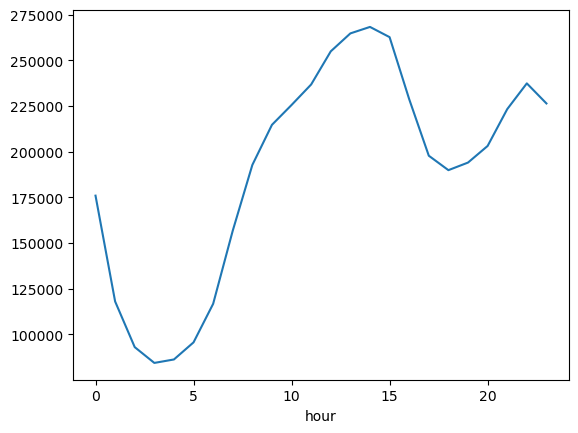

In [28]:
df0.groupby('hour').size().plot()

<Axes: xlabel='week'>

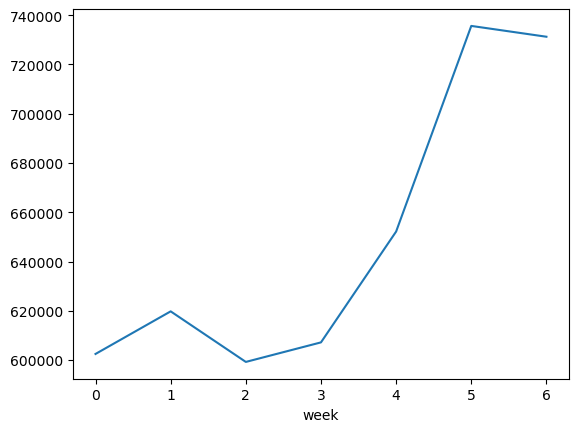

In [29]:
df0.groupby('week').size().plot()

- 签到特征

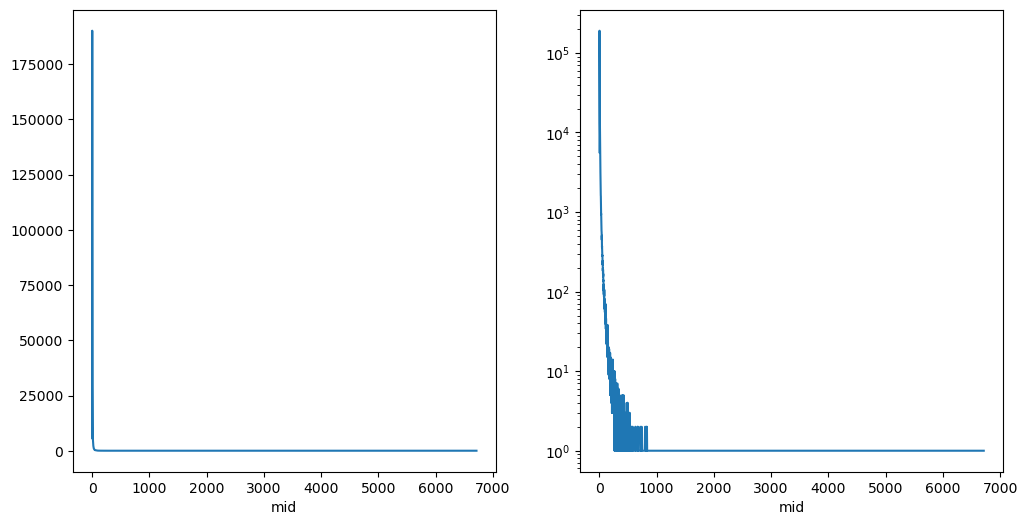

In [30]:
# 用户签到数量的数量分布 
# df0.groupby('userid').agg({'mid':'count'}).reset_index().groupby('mid').size().plot(loglog=True) 
fig, ax = plt.subplots(1,2,figsize=(12,6))

df0.groupby('userid').agg({'mid':'count'}).reset_index().groupby('mid').size().plot(ax=ax[0])
df0.groupby('userid').agg({'mid':'count'}).reset_index().groupby('mid').size().plot(ax=ax[1])
ax[1].set_yscale('log')

In [31]:
df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 4611742 entries, 0 to 6550911
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   mid            4611742 non-null  int64         
 1   userid         4611742 non-null  int64         
 2   ts_created     4611742 non-null  datetime64[ns]
 3   poiid          4611742 non-null  object        
 4   title          4611742 non-null  object        
 5   category_name  3814958 non-null  object        
 6   lon            4611742 non-null  float64       
 7   lat            4611742 non-null  float64       
 8   text           4611742 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 351.8+ MB


## 签到网络

In [33]:
import networkx as nx

In [34]:
# 归一化边权重
checkins_poi['weight1'] =  checkins_poi['weight'] / max(checkins_poi['weight'])

<Axes: xlabel='weight'>

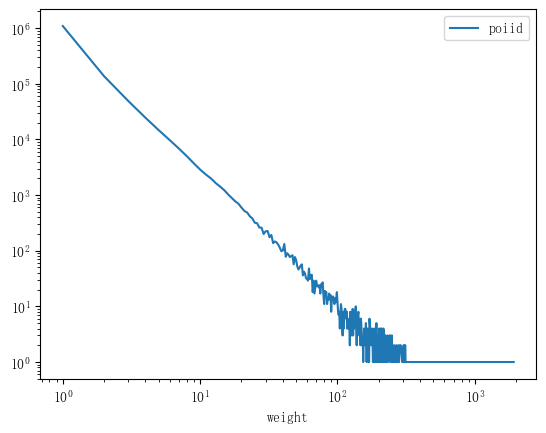

In [35]:
checkins_poi.groupby('weight').agg({'poiid':'count'}).plot(loglog=True)

In [36]:
# 构建签到网
checkins_poi = checkins_poi.drop(columns='weight').rename(columns={'weight1':'weight'})
G = nx.from_pandas_edgelist(checkins_poi, 'poiid', 'next_poiid', edge_attr=['weight'])

In [37]:
df0 = df.drop_duplicates(subset='poiid')[['poiid','lon','lat']].set_index('poiid')[['lon', 'lat']]
df0

,lon,lat
poiid,,
8008631011500000058,121.546052,31.243452
8008631010101000000,121.482341,31.236967
B2094757D068A5F8489D,121.482096,31.174727
B2094757D068A4F5479C,121.504022,31.195252
8008631010500000009,121.368920,31.218629
...,...,...
B2094550DA64A5F8499D,121.521012,31.140423
B2094256D76DA4FD499A,121.383932,31.133100
B2094751DA6DA1F54893,121.247801,31.386573


In [38]:
# 添加节点位置信息
df0 = df.drop_duplicates(subset='poiid')[['poiid','lon','lat']].set_index('poiid')[['lon', 'lat']]
node_positions = {poiid: (lon,lat) for poiid, (lon,lat) in zip(df0.index, zip(df0.lon, df0.lat))}
nx.set_node_attributes(G, node_positions, 'pos')

In [39]:
# 判断是否有多余子图
G_ = G.to_undirected()  # 无向图
subgraphs = list(nx.connected_components(G_))  # 获取连通子图

for i,g in enumerate(subgraphs):
    G_len = len(G_.subgraph(subgraphs[i]))
    print(i,G_len)

G = G_.subgraph(subgraphs[0])

0 22863
1 2


In [40]:
# 创建节点到索引的映射
node_to_index = {node: idx for idx, node in enumerate(G.nodes())}
index_to_node = {idx: node for node, idx in node_to_index.items()}

In [41]:
# G['8008631010100000013']['8008631010100000015']
G.nodes['8008631010100000018']

{'pos': (121.463823028091, 31.2079295817092)}

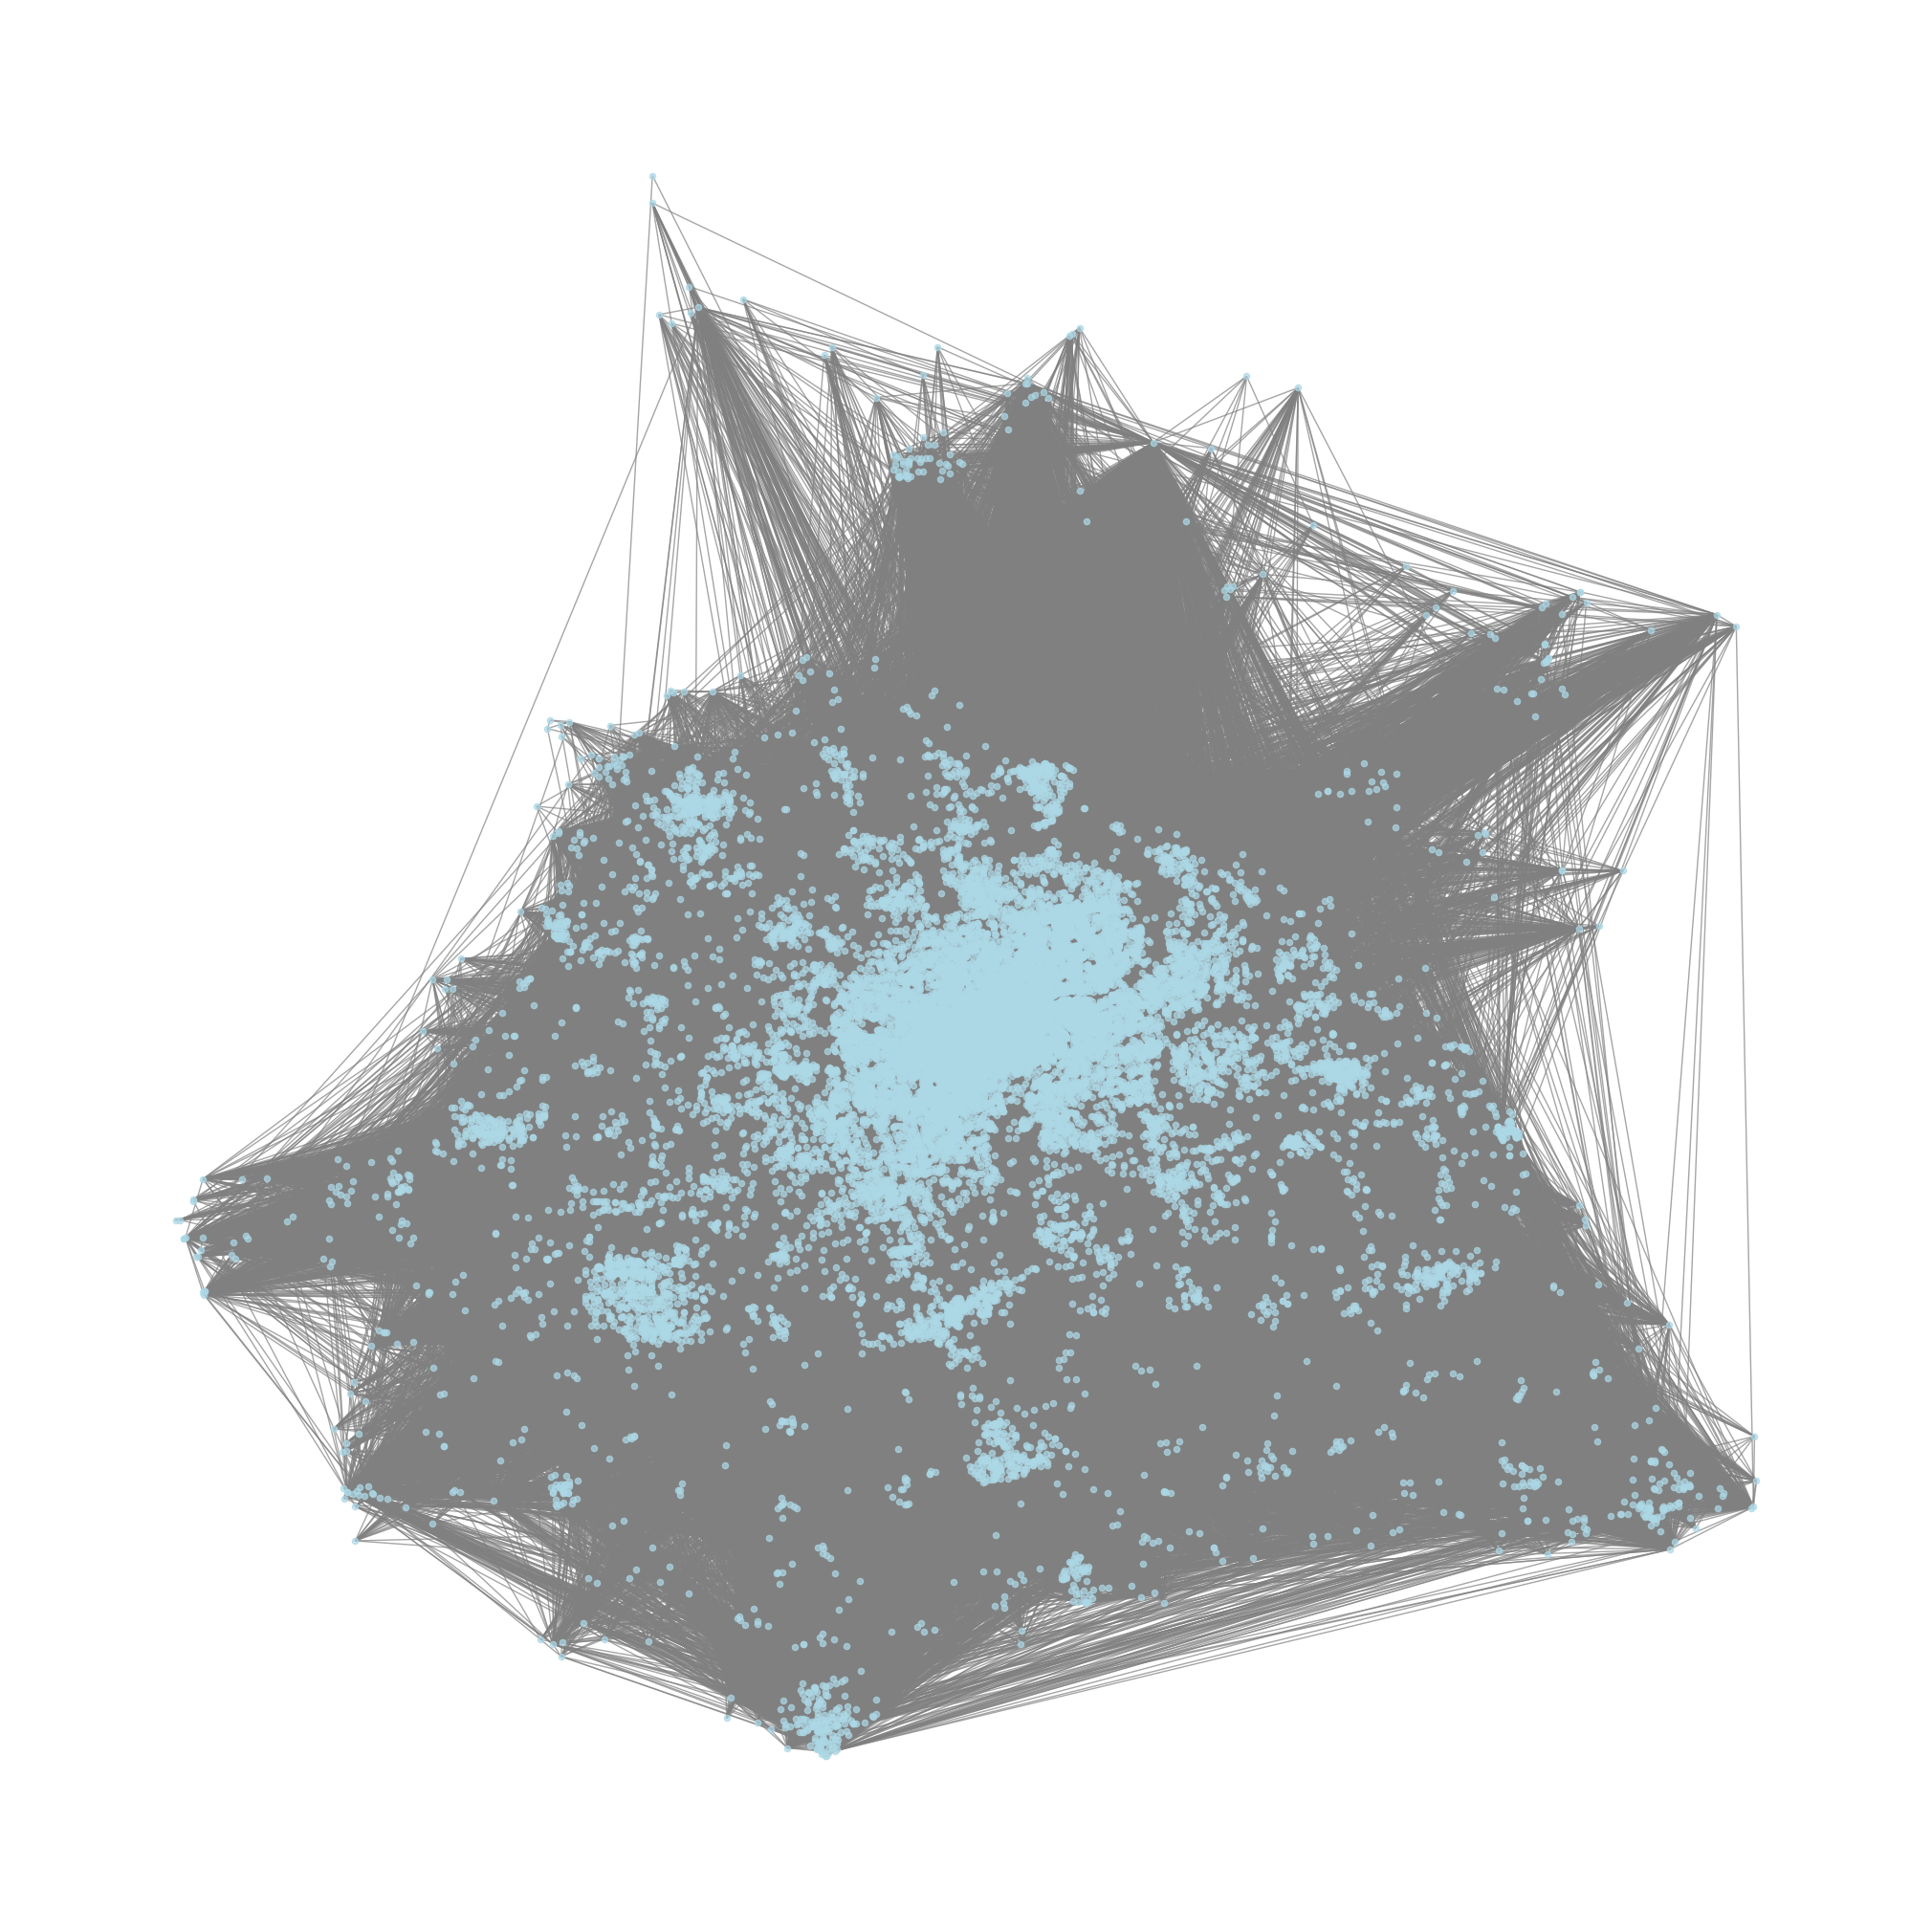

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))
pos = nx.get_node_attributes(G, 'pos')
nx.draw(G,
        pos, 
        with_labels=False, 
        font_weight='bold', 
        node_size=20, 
        node_color='lightblue', 
        font_size=2, 
        font_color='black', 
        edge_color='gray', 
        linewidths=1, 
        alpha=0.7)
# edge_labels = nx.get_edge_attributes(G, 'weight')
plt.show()

In [43]:
print(f'边的数量: {len(list(G.edges))}') 
print(f'节点的数量: {len(list(G.nodes))}')

边的数量: 1115679
节点的数量: 22863


In [44]:
import pickle

with open('data/final_data/network/shanghai_2019.pkl', 'wb') as f:
    pickle.dump(G, f)

In [46]:
SAVE = ['mid','userid','poiid','text','ts_created','title','category_name','lon','lat']
df.reset_index(drop=True)[SAVE].to_csv('data/processing/shanghai_2019_network.csv', index=False)

## 编码文本

- bert
- finetune-bert

In [1]:
import pandas as pd
import numpy as np

import torch
from sentence_transformers import SentenceTransformer

torch.cuda.set_device(0)

In [2]:
df = pd.read_csv('data/processing/shanghai_2019_network.csv')

# 加载预训练的BERT模型
model = SentenceTransformer('../model/bert-base-chinese')
# model = SentenceTransformer('../model/shanghai')  # finetune-bert

In [3]:
# 句向量
embeddings = model.encode(df.text)
embeddings = pd.DataFrame(data=embeddings, columns=['vector_'+str(i+1) for i in range(embeddings.shape[1])])

In [4]:
# 聚合到地点  
embeddings['poiid'] = df['poiid']
place_embeddings = embeddings.groupby(by='poiid').mean().reset_index()

In [5]:
# 正则化
def l2_normalize(column):
    norm = np.linalg.norm(column)
    return column / norm

place_embeddings1 = place_embeddings.drop(columns='poiid').apply(l2_normalize, axis=0)
place_embeddings1['poiid'] = place_embeddings['poiid']

In [6]:
place_embeddings1.to_csv('data/final_data/place_embedding/shanghai_2019_bert.csv', index=False)

## torch_geometry

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import pickle
import json

import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx

### 节点属性

In [2]:
place_embeddings = pd.read_csv('data/final_data/place_embedding/shanghai_2019_bert.csv')


with open('data/final_data/network/shanghai_2019.pkl', 'rb') as f:
    G = pickle.load(f)

In [3]:
node_attributes = {row['poiid']: row.drop('poiid').to_dict() for _, row in place_embeddings.iterrows()}
nx.set_node_attributes(G, node_attributes, 'attributes')

In [4]:
# 8008631010100000015
G.nodes['8008631010100000018']

{'pos': (121.463823028091, 31.2079295817092),
 'attributes': {'vector_1': 0.0066554355,
  'vector_2': -0.0021699758,
  'vector_3': 0.0025685236,
  'vector_4': -0.0027589654,
  'vector_5': -0.006680647,
  'vector_6': -0.0024813064,
  'vector_7': 0.004654567,
  'vector_8': 0.0040532905,
  'vector_9': -0.0016656339,
  'vector_10': -0.00055957586,
  'vector_11': 0.00015245588,
  'vector_12': 0.006474804,
  'vector_13': -0.0060635516,
  'vector_14': 0.0068039224,
  'vector_15': -0.005918791,
  'vector_16': -0.005624587,
  'vector_17': 0.0043604993,
  'vector_18': -0.005305121,
  'vector_19': -0.0066880765,
  'vector_20': -0.004603802,
  'vector_21': 0.0044025043,
  'vector_22': 0.006126593,
  'vector_23': -0.007030135,
  'vector_24': 0.0029258577,
  'vector_25': 0.005603753,
  'vector_26': -0.006622863,
  'vector_27': 0.0062939576,
  'vector_28': -0.0058517624,
  'vector_29': -0.006811307,
  'vector_30': 0.00014723584,
  'vector_31': 0.0070014307,
  'vector_32': 0.005265924,
  'vector_33': 

### 构建Dataset

In [7]:
# 将节点属性和边属性转换为PyTorch张量
# 节点特征
node_features = [list(G.nodes[u]['attributes'].values()) for u in G.nodes()]
node_features = torch.tensor(node_features, dtype=torch.float)
# 边索引
node_to_index = {node: index for index,node in enumerate(G.nodes)}
# .t() 是transpose方法，用于转置张量的维度。对于包含边的张量来说，如果原张量表示的是从行到列的边连接关系，那么转置后可以得到从列到行的边连接关系
# .contiguous() 方法确保张量在内存中是连续存储的，这对于某些需要连续内存空间的操作（如卷积或一些矩阵运算）是必要的
edge_indices = torch.tensor([[node_to_index[edge[0]], node_to_index[edge[1]]] for edge in G.edges()], dtype=torch.long).t().contiguous()
# 边权重
edge_weights = torch.tensor([G[u][v]['weight'] for u, v in G.edges], dtype=torch.float).view(-1, 1)  # 转 1 维 1 列 tensor

# 类别标签
with open('data/final_data/poi_label/shanghai_2019.json','r',encoding='utf8')as f:
    poiid_label = json.load(f)
node_y = torch.tensor([poiid_label.get(i, 9) for i in G.nodes])

In [8]:
# 创建PyG的Data对象
dataset = Data(x=node_features, edge_index=edge_indices, edge_attr=edge_weights, y=node_y, num_classes=len(node_y.unique())-1)

print(f'dataset: {dataset}')
print(f'Number of data_attr: {len(dataset)}') 
print(f'Number of nodes: {dataset.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')

dataset: Data(x=[22863, 768], edge_index=[2, 1115679], edge_attr=[1115679, 1], y=[22863], num_classes=9)
Number of data_attr: 5
Number of nodes: 22863
Number of features: 768


### 数据划分

In [9]:
UNKNOWN = 9

# 确定有标签、无标签节点索引
labeled_nodes = (dataset.y != UNKNOWN)

In [10]:
# 分训练集和验证集
# np.random.seed(1)

train_index = []
for i in [node_ for node_ in node_y.unique() if node_!=UNKNOWN]:
    class_mask = labeled_nodes & (dataset.y == i)
    class_nodes = np.where(class_mask)[0]
    train_index.extend(np.random.choice(class_nodes, size=200, replace=False))  # size: 随机选择的数量

val_index = []
for i in [node_ for node_ in node_y.unique() if node_!=UNKNOWN]:        
    class_mask = labeled_nodes & (dataset.y == i)
    class_nodes = np.where(class_mask)[0]
    class_nodes = np.setdiff1d(class_nodes, train_index)  # 去除训练集索引
    val_index.extend(class_nodes)

In [12]:
# 标记
dataset.train_mask = torch.zeros_like(dataset.y, dtype=torch.bool)
dataset.val_mask = torch.zeros_like(dataset.y, dtype=torch.bool)
dataset.train_mask[train_index] = True
dataset.val_mask[val_index] = True

In [14]:
np.unique(dataset.y[dataset.train_mask], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([200, 200, 200, 200, 200, 200, 200, 200, 200]))

In [15]:
np.unique(dataset.y[dataset.val_mask], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([ 866,  489,  154,  260, 2351,  833,  667,  196,  473]))

In [16]:
torch.save(dataset, 'data/final_data/dataset_torch/shanghai_2019_bert.pth')